#**SEIS-639 Brain Tumor Classification**
## CNN v2

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Mounting my personal google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting working directory
%cd drive/'My Drive'/

/content/drive/My Drive


In [ ]:
# To see if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


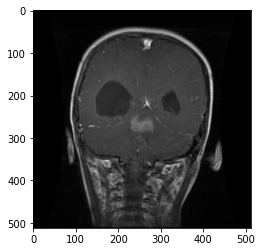

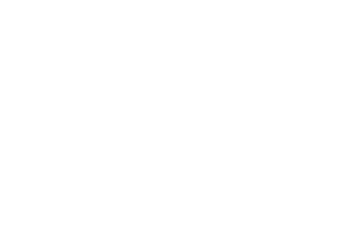

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

data_dir = "dataset/Training"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

for category in CATEGORIES:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

(-0.5, 149.5, 149.5, -0.5)

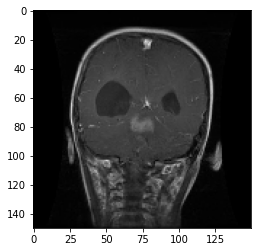

In [ ]:
img_size = 150
new_array = cv2.resize(img_array,(img_size,img_size))    
plt.imshow(new_array,cmap = "gray")
plt.axis("on")

In [ ]:
new_array.shape

(150, 150, 3)

In [ ]:
# Define training data
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(data_dir,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(img_size,img_size)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [ ]:
# Define X and y
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,img_size,img_size)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)

(2870, 150, 150)


In [ ]:
 # convert to one-hot-encoding
from keras.utils.np_utils import to_categorical
y = to_categorical(y, num_classes = 4)

In [ ]:
# Train and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2296, 150, 150, 1)
x_test shape (574, 150, 150, 1)
y_train shape (2296, 4)
y_test shape (574, 4)


In [ ]:
epochs = 100
batch_size = 40

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False
                             )
datagen.fit(X_train)

train_data_gen = datagen.flow(X_train,
                              Y_train, 
                              batch_size=batch_size)

validation_data_gen = (X_val, Y_val)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization

# CNN Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size=(5, 5), padding = 'Same', input_shape=(150, 150, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size=(5, 5), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size=(3, 3), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size=(2, 2), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 256, kernel_size=(2, 2), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Fully Connected Layers
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

import time
start = time.time()
model.compile(optimizer='adam', 
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=15)

# Fit model
fitted_model = model.fit(train_data_gen,
                         validation_data = validation_data_gen,
                         epochs=epochs,
                         steps_per_epoch = X_train.shape[0] // batch_size,
                         callbacks=[es],
                         verbose=1
                         )
finish = time.time()
print("training time: ", (finish-start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1664      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       204928    
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       1

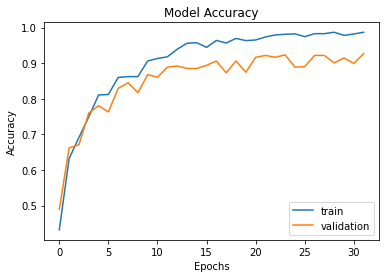

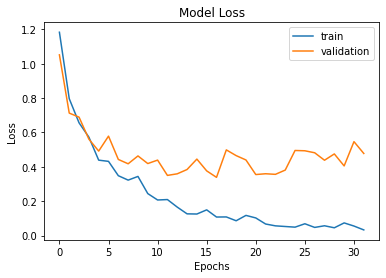

In [ ]:
# History for accuracy
plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# History for loss
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# Reports
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(X_val)

# Labels are still one-hot encoded, for that reason we need to convert them to single-digit ones
y_pred = np.argmax(Y_pred, axis=1)
Y_val = np.argmax(Y_val, axis=1)


print('Confusion Matrix')
print(confusion_matrix(Y_val, y_pred))
print()
print('Classification Report')
report = classification_report(Y_val, y_pred, target_names=CATEGORIES)
print(report)

Confusion Matrix
[[168  11   0   0]
 [  9 150   8   2]
 [  2   0  67   1]
 [  2   5   2 147]]

Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.94      0.93       179
meningioma_tumor       0.90      0.89      0.90       169
        no_tumor       0.87      0.96      0.91        70
 pituitary_tumor       0.98      0.94      0.96       156

        accuracy                           0.93       574
       macro avg       0.92      0.93      0.93       574
    weighted avg       0.93      0.93      0.93       574



Confusion matrix, without normalization


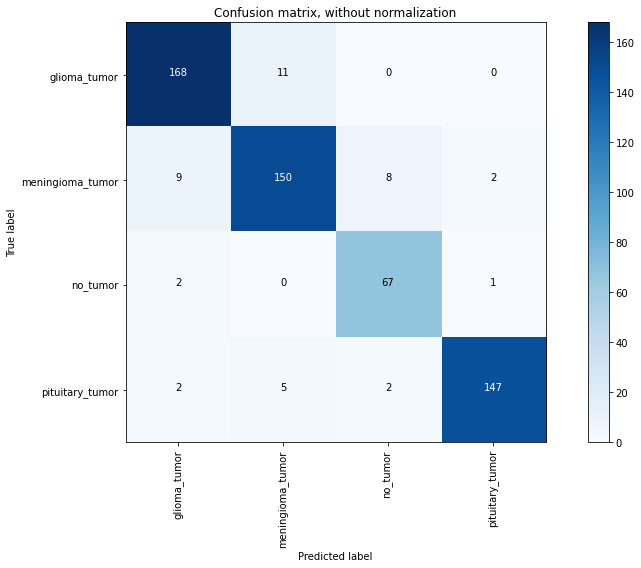

In [ ]:
# Defining confusion matrix function to plot that can be normalized as well

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plotting my model
cnf_matrix = confusion_matrix(Y_val, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,8))
plot_confusion_matrix(cnf_matrix, classes=CATEGORIES,
                      title='Confusion matrix, without normalization')
plt.tight_layout()

In [ ]:
#model.save('model_cnn_final')

INFO:tensorflow:Assets written to: model_cnn_final/assets
